# Ejercicio Canavos Página 448

El objetivo del ejercicio es ajustar un modelo de regresión lineal que nos permita estimar el Salario Inicial de los estudiantes universitarios como una función de la calificación promedio.

In [1]:
# Tratamiento de datos

import pandas as pd
import numpy as np

# Gráficos

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado

from scipy.stats import pearsonr
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configuración warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importar los datos

data = pd.read_csv('./../dataset/ejemplo.csv')
data.head(5)

,CALIFICACIÓN PROMEDIO,SALARIO INICIAL
0,2.95,18.5
1,3.20,20.0
2,3.40,21.1
3,3.60,22.4
4,3.20,21.2


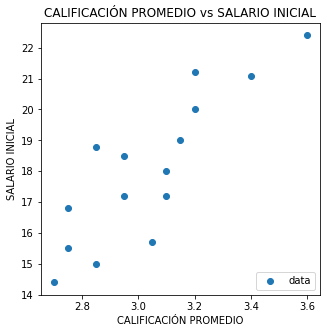

In [3]:
# Gráfico de dispersión

x = data['CALIFICACIÓN PROMEDIO']
Y = data['SALARIO INICIAL']
plt.figure(figsize=(5,5))
plt.scatter(x, Y, marker='o', label='data')
plt.xlabel('CALIFICACIÓN PROMEDIO')
plt.ylabel('SALARIO INICIAL')
plt.title('CALIFICACIÓN PROMEDIO vs SALARIO INICIAL')
plt.legend(loc='lower right')
plt.show()


In [4]:
# Correlación lineal entre las dos variables

prueba_correlacion = pearsonr(x, Y)
print('Coeficiente de Correlación de Pearson: ' + str(prueba_correlacion[0]))
print('P-value: ' + str(prueba_correlacion[1]))

Coeficiente de Correlación de Pearson: 0.8476342100087885
P-value: 6.59819025231516e-05


Debido al gráfico de dispersión (aunque muestra cierta dispersión), al valor del coeficiente de Pearson (r=0.85) y a la prueba de correlación significativa (P-value=0.00006598), se muestra una asociación lineal entre la calificación promedio (x) y el salario inicial (Y); por lo que se ajustará un modelo de regresión lineal simple con el objetivo de predecir el salario inicial de un estudiante en función de su calificación promedio.

**ANÁLISIS EXPLORATORIO DE LOS DATOS**

In [5]:
# Nombre de las columnas

data.columns

Index(['CALIFICACIÓN PROMEDIO', 'SALARIO INICIAL'], dtype='object')

In [6]:
# Dimensión de los datos

data.shape

(15, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CALIFICACIÓN PROMEDIO  15 non-null     float64
 1   SALARIO INICIAL        15 non-null     float64
dtypes: float64(2)
memory usage: 368.0 bytes


In [8]:
# Estadísticos descriptivos

data.describe()

,CALIFICACIÓN PROMEDIO,SALARIO INICIAL
count,15.000000,15.000000
mean,3.040000,18.053333
std,0.251567,2.409465
min,2.700000,14.400000
25%,2.850000,16.250000
50%,3.050000,18.000000
75%,3.175000,19.500000
max,3.600000,22.400000


# Estudio de la distribución de la variable respuesta Y: Salario Inicial

**1. Gráfico**

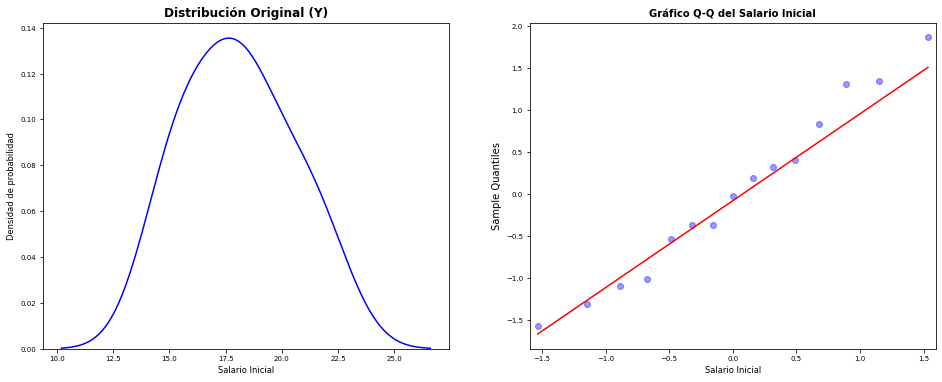

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
Y =  data['SALARIO INICIAL']
sns.distplot(
    Y,
    hist    = False,
    kde = True,
    color   = "blue",
    ax = axes[0]
)
axes[0].set_title("Distribución Original (Y)", fontweight = "bold")
axes[0].set_xlabel('Salario Inicial', fontsize='small')
axes[0].set_ylabel('Densidad de probabilidad', fontsize='small')
axes[0].tick_params(labelsize = 7)


# Gráfico Q-Q

sm.qqplot(
    Y,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = axes[1]
)
axes[1].set_title('Gráfico Q-Q del Salario Inicial', fontsize = 10,
             fontweight = "bold")
axes[1].set_xlabel('Salario Inicial', fontsize='small')
axes[1].tick_params(labelsize = 7)

**2. Métodos analíticos asimetría y curtosis**

In [10]:
print('Coeficiente de Curtosis:', stats.kurtosis(Y))
print('Coeficiente de Asimetría:', stats.skew(Y))

Coeficiente de Curtosis: -0.9599587595583778
Coeficiente de Asimetría: 0.21233887921489958


**3. Contraste de hipótesis**


$H_0 =$ La distribución de los datos se ajusta a una distribución normal y $H_1 =$ La distribución de los datos NO se ajusta a una distribución normal.

Si el nivel de significancia es $\alpha=0.05$ ...

In [11]:
# Test Shapiro-Wilk

shapiro_test = stats.shapiro(Y)
shapiro_test

ShapiroResult(statistic=0.9678089022636414, pvalue=0.824384868144989)

In [12]:
# Test D'Agostino's K-squared

k2, p_value = stats.normaltest(Y)
print(f"Estadístico = {k2}, p-value = {p_value}")

Estadístico = 0.7799178015701234, p-value = 0.6770847015760069


En ambos test el p-value > $\alpha$... indicando que no existe evidencia suficiente para rechazar la hipótesis nula $H_0$. El p-value no es significativo.

La evidencia muestral no es suficiente para rechazar la hipótesis de que la variable de respuesta (Salario Inicial) se ajusta a una distribución normal.

No poder rechazar la hipótesis nula trae consigo que los estimadores de mínimos cuadrados de $\beta_0$ y $\beta_1$ (iguales a los estimadores de Máxima Verosimilitud-suponiendo normalidad de los errores aleatorios) tengan las propiedades deseables de consistencia, suficiencia y de varianza mínima; además que nos permiten desarrollar criterios inferenciales para $\beta_0$ y $\beta_1$.

# AJUSTE DEL MODELO DE REGRESIÓN LINEAL SIMPLE

**1. Sklearn**

In [13]:
# División de los datos en train y test
# ==============================================================================

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
                                        x.values.reshape(-1,1),
                                        Y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [14]:
# Creación del modelo (Entrenamiento)
# ==============================================================================
modelo_lineal_simple = LinearRegression()
modelo_lineal_simple.fit(X = X_entrenamiento, y = y_entrenamiento)

LinearRegression()

In [15]:
# Información del modelo
# ==============================================================================
intercepto = modelo_lineal_simple.intercept_
coeficiente = modelo_lineal_simple.coef_.flatten()
print("")
print(f"Intercepto:", intercepto)
print("Coeficiente:", coeficiente)
print("Coeficiente de determinación R^2:", modelo_lineal_simple.score(X_entrenamiento, y_entrenamiento))


Intercepto: [-7.21131985]
Coeficiente: [8.31791908]
Coeficiente de determinación R^2: 0.752900429773425


La ecuación estimada de regresión es:

$$
\hat{y} = -7.21 + 8.31 x
$$

El valor de $R^2= 0.7529$, significa que el $75.29\%$ de la variabilidad total en los salarios iniciales (Y) es explicada por la presencia lineal de la calificación promedio (x) en el modelo de regresión.

In [16]:
# Error del modelo estimado

predicciones_entrenamiento = modelo_lineal_simple.predict(X = X_entrenamiento)

rmse = mean_squared_error(
        y_true  = y_entrenamiento,
        y_pred  = predicciones_entrenamiento,
        squared = False
       )
print("")
print(f"El error (RMSE) de test es: {rmse}")


El error (RMSE) de test es: 1.2793793717072979


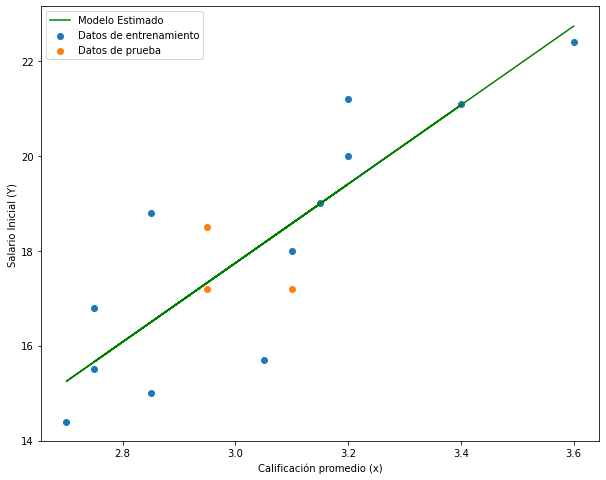

In [17]:
def recta_estimada(x):
    return intercepto + coeficiente * x

modelo_estimado = list(map(recta_estimada,X_entrenamiento))
plt.figure(figsize=(10,8))
plt.plot(X_entrenamiento, modelo_estimado, color='green')
plt.scatter(X_entrenamiento, y_entrenamiento)
plt.scatter(X_prueba, y_prueba)
plt.legend(['Modelo Estimado','Datos de entrenamiento','Datos de prueba'])
plt.xlabel("Calificación promedio (x)")
plt.ylabel("Salario Inicial (Y)")
plt.show()

In [18]:
# # Error de test del modelo 

predicciones_prueba = modelo_lineal_simple.predict(X = X_prueba)

rmse = mean_squared_error(
        y_true  = y_prueba,
        y_pred  = predicciones_prueba,
        squared = False
       )
print("")
print(f"El error (RMSE) de test es: {rmse}")


El error (RMSE) de test es: 1.0458686806135336


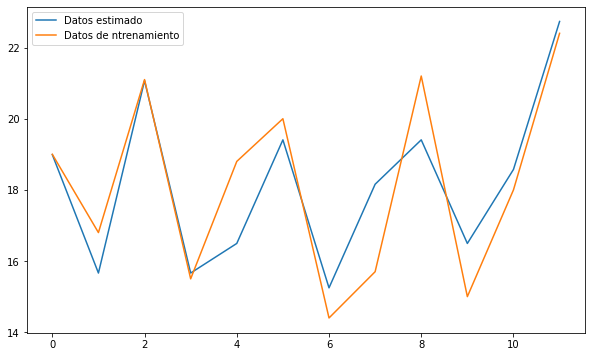

In [19]:
# Valores de entrenamiento vs valores estimados
# ==============================================================================
modelo_estimado = np.array(modelo_estimado)
plt.figure(figsize=(10,6))
plt.plot(modelo_estimado)
plt.plot(y_entrenamiento)
plt.legend(["Datos estimado", "Datos de ntrenamiento"])
plt.show()